### Action1
资金流入流出预测
https://tianchi.aliyun.com/competition/entrance/231573/information
数据集一共包括4张表：用户基本信息数据、用户申购赎回数据、收益率表和银行间拆借利率表
2.8万用户，284万行为数据，294天拆解利率，427天收益率
2013-07-01到2014-08-31，预测2014年9月的申购和赎回

#### 数据加载

In [320]:
import pandas as pd
data = pd.read_csv('./user_balance_table.csv', parse_dates=['report_date'])
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,0,0,0,61,NaN,NaN,NaN,NaN
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,0,0,0,60,0.0,0.0,0.0,12500.0
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,0,0,0,2297,NaN,NaN,NaN,NaN
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,31732,0,31732,2298,NaN,NaN,NaN,NaN


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840421 entries, 0 to 2840420
Data columns (total 18 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              int64         
 1   report_date          datetime64[ns]
 2   tBalance             int64         
 3   yBalance             int64         
 4   total_purchase_amt   int64         
 5   direct_purchase_amt  int64         
 6   purchase_bal_amt     int64         
 7   purchase_bank_amt    int64         
 8   total_redeem_amt     int64         
 9   consume_amt          int64         
 10  transfer_amt         int64         
 11  tftobal_amt          int64         
 12  tftocard_amt         int64         
 13  share_amt            int64         
 14  category1            float64       
 15  category2            float64       
 16  category3            float64       
 17  category4            float64       
dtypes: datetime64[ns](1), float64(4), int64(13)
memory usage: 390.

In [2]:
# 计算每天的购买量和赎回量
total_balance = data.groupby(['report_date'])['total_purchase_amt', 'total_redeem_amt'].sum()
purchase = total_balance[['total_purchase_amt']]
redeem = total_balance[['total_redeem_amt']]
total_balance

<ipython-input-2-b69a2cf17877>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_balance = data.groupby(['report_date'])['total_purchase_amt', 'total_redeem_amt'].sum()


,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587
...,...,...
2014-08-27,302194801,468164147
2014-08-28,245082751,297893861
2014-08-29,267554713,273756380


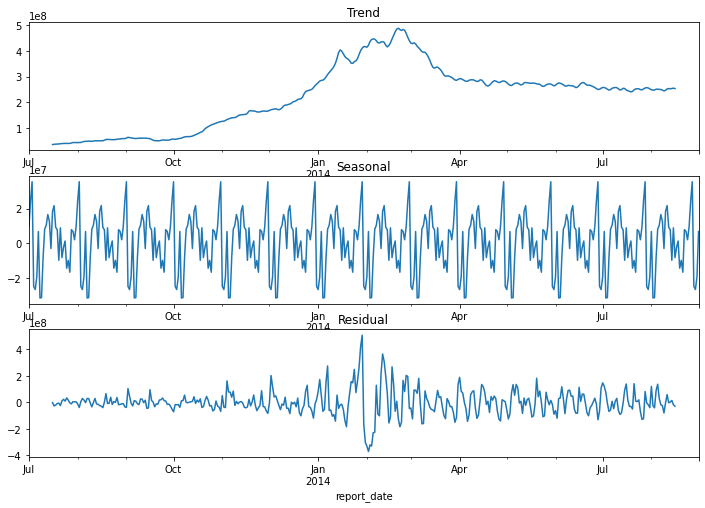

In [4]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 对数据进行STL分解(Trend + Seasonal + Residual)
def plot_stl(data):
    result = sm.tsa.seasonal_decompose(data, period=30)
    # 可视化
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    result.trend.plot(ax=ax1, title='Trend')
    result.seasonal.plot(ax=ax2, title='Seasonal')
    result.resid.plot(ax=ax3, title='Residual')

plot_stl(purchase.total_purchase_amt)

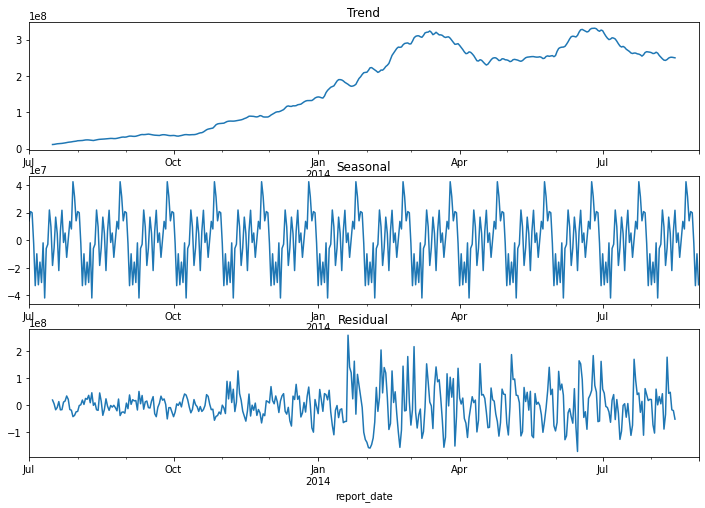

In [5]:
plot_stl(redeem.total_redeem_amt)

#### Prophet

In [23]:
# 设置保留字ds,y
purchase['ds'] = purchase.index
purchase.rename(columns={'total_purchase_amt': 'y'}, inplace=True)
purchase = purchase.reset_index(drop=True)
purchase

,y,ds
0,32488348,2013-07-01
1,29037390,2013-07-02
2,27270770,2013-07-03
3,18321185,2013-07-04
4,11648749,2013-07-05
...,...,...
422,302194801,2014-08-27
423,245082751,2014-08-28
424,267554713,2014-08-29
425,199708772,2014-08-30


In [26]:
redeem['ds'] = redeem.index
redeem.rename(columns={'total_redeem_amt': 'y'}, inplace=True)
redeem = redeem.reset_index(drop=True)
redeem

,y,ds
0,5525022,0
1,2554548,1
2,5953867,2
3,6410729,3
4,2763587,4
...,...,...
422,468164147,422
423,297893861,423
424,273756380,424
425,196374134,425


In [39]:
from fbprophet import Prophet

# 模型训练
# 对于purchase
model = Prophet(changepoint_prior_scale=0.5, weekly_seasonality=True, seasonality_prior_scale=0.1)
model.fit(purchase)
future = model.make_future_dataframe(periods=30)
purchase_pred = model.predict(future)
print(purchase_pred.columns)
purchase_pred

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-07-01,2.678865e+07,-3.594558e+07,1.779038e+08,2.678865e+07,2.678865e+07,4.476942e+07,4.476942e+07,4.476942e+07,4.476942e+07,4.476942e+07,4.476942e+07,0.0,0.0,0.0,7.155808e+07
1,2013-07-02,2.718294e+07,-2.536466e+07,1.827461e+08,2.718294e+07,2.718294e+07,4.756117e+07,4.756117e+07,4.756117e+07,4.756117e+07,4.756117e+07,4.756117e+07,0.0,0.0,0.0,7.474411e+07
2,2013-07-03,2.757723e+07,-4.186285e+07,1.687381e+08,2.757723e+07,2.757723e+07,3.771528e+07,3.771528e+07,3.771528e+07,3.771528e+07,3.771528e+07,3.771528e+07,0.0,0.0,0.0,6.529251e+07
3,2013-07-04,2.797152e+07,-6.001219e+07,1.564557e+08,2.797152e+07,2.797152e+07,1.954113e+07,1.954113e+07,1.954113e+07,1.954113e+07,1.954113e+07,1.954113e+07,0.0,0.0,0.0,4.751266e+07
4,2013-07-05,2.836581e+07,-9.476870e+07,1.218599e+08,2.836581e+07,2.836581e+07,-1.784541e+07,-1.784541e+07,-1.784541e+07,-1.784541e+07,-1.784541e+07,-1.784541e+07,0.0,0.0,0.0,1.052040e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,2014-09-26,2.383170e+08,1.166000e+08,3.363770e+08,2.221490e+08,2.582582e+08,-1.784541e+07,-1.784541e+07,-1.784541e+07,-1.784541e+07,-1.784541e+07,-1.784541e+07,0.0,0.0,0.0,2.204716e+08
453,2014-09-27,2.380711e+08,5.389007e+07,2.788164e+08,2.207755e+08,2.588984e+08,-6.950784e+07,-6.950784e+07,-6.950784e+07,-6.950784e+07,-6.950784e+07,-6.950784e+07,0.0,0.0,0.0,1.685632e+08
454,2014-09-28,2.378251e+08,7.153932e+07,2.844961e+08,2.195797e+08,2.597183e+08,-6.223375e+07,-6.223375e+07,-6.223375e+07,-6.223375e+07,-6.223375e+07,-6.223375e+07,0.0,0.0,0.0,1.755913e+08
455,2014-09-29,2.375791e+08,1.788360e+08,3.921311e+08,2.176746e+08,2.606735e+08,4.476942e+07,4.476942e+07,4.476942e+07,4.476942e+07,4.476942e+07,4.476942e+07,0.0,0.0,0.0,2.823486e+08


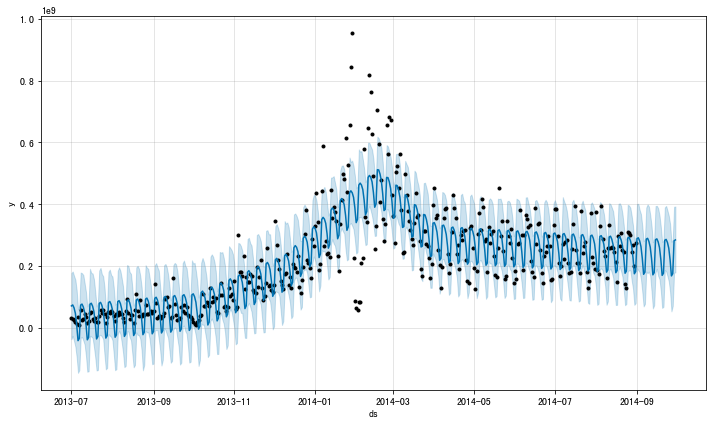

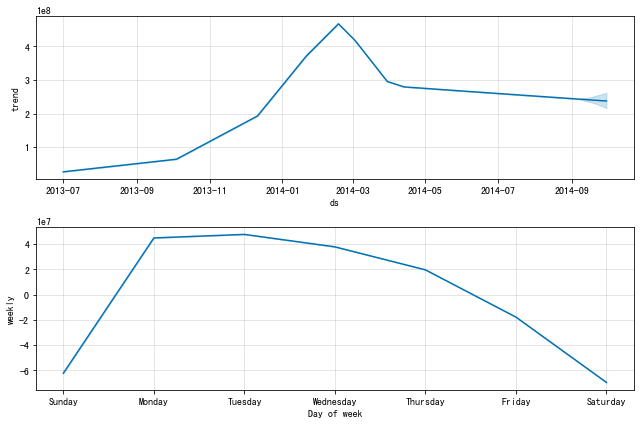

In [47]:
# 可视化呈现
model.plot(purchase_pred)
model.plot_components(purchase_pred)
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


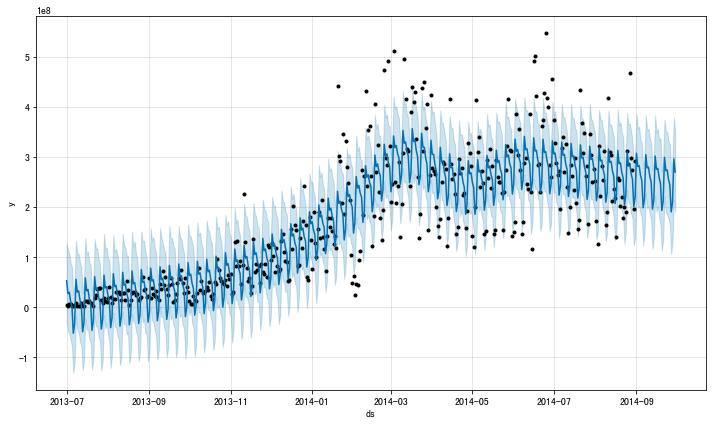

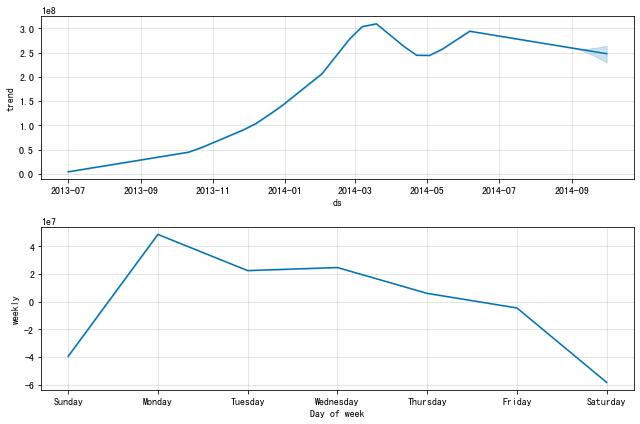

In [75]:
# 对于redeem
model2 = Prophet(changepoint_prior_scale=0.8, weekly_seasonality=True, seasonality_prior_scale=0.1, n_changepoints=30)
model2.fit(redeem)
future = model2.make_future_dataframe(periods=30)
redeem_pred = model2.predict(future)

# 可视化呈现

model2.plot(redeem_pred)
model2.plot_components(redeem_pred)
plt.show()

In [88]:
# 得到预测结果
purchase2 = purchase_pred[(purchase_pred['ds'] >= '2014-09-01') & (purchase_pred['ds'] <= '2014-09-30')][['ds','yhat']]
redeem2 = purchase_pred[(redeem_pred['ds'] >= '2014-09-01') & (redeem_pred['ds'] <= '2014-09-30')][['ds','yhat']]

# 合并结果
result = pd.DataFrame()
result['ds'] = purchase2.ds
result['total_purchase_amt'] = purchase2.yhat
result['total_redeem_amt'] = redeem2.yhat

In [95]:
result['ds'] = result['ds'].apply(lambda x: str(x).replace('-', '')[:8])

In [96]:
result

,ds,total_purchase_amt,total_redeem_amt
427,20140901,2.892357e+08,2.892357e+08
428,20140902,2.917815e+08,2.917815e+08
429,20140903,2.816896e+08,2.816896e+08
430,20140904,2.632695e+08,2.632695e+08
431,20140905,2.256370e+08,2.256370e+08
432,20140906,1.737286e+08,1.737286e+08
433,20140907,1.807567e+08,1.807567e+08
434,20140908,2.875139e+08,2.875139e+08
435,20140909,2.900597e+08,2.900597e+08
436,20140910,2.799678e+08,2.799678e+08


In [98]:
result.to_csv('./prophet.csv', header=None, index=False)
# finalScore:104.9142

#### ARIMA

In [11]:
import warnings

warnings.filterwarnings('ignore')

##### 对于购买量purchase

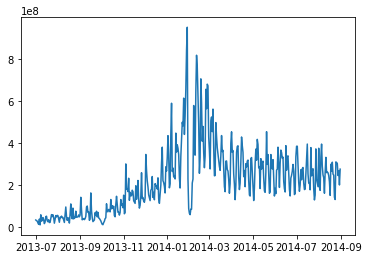

In [28]:
plt.plot(purchase.total_purchase_amt)
plt.show()

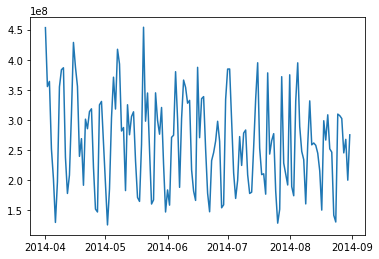

In [12]:
# 局部细节可视化
purchase1 = purchase[(purchase.index >= '2014-04-01') & (purchase.index <= '2014-08-31')]
plt.plot(purchase1.total_purchase_amt)
# date_range = pd.date_range('2014-04-01', '2014-08-31')
# plt.xticks(date_range, rotation=90)
plt.show()

In [14]:
# 平稳性检验（原假设H0为非平稳）
def adf(data):
    t=sm.tsa.stattools.adfuller(data)
    output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
    output['value']['Test Statistic Value'] = t[0]
    output['value']['p-value'] = t[1]
    output['value']['Lags Used'] = t[2]
    output['value']['Number of Observations Used'] = t[3]
    output['value']['Critical Value(1%)'] = t[4]['1%']
    output['value']['Critical Value(5%)'] = t[4]['5%']
    output['value']['Critical Value(10%)'] = t[4]['10%']
    print(output)

In [15]:
adf(purchase)

                                value
Test Statistic Value         -1.58988
p-value                      0.488675
Lags Used                          18
Number of Observations Used       408
Critical Value(1%)           -3.44648
Critical Value(5%)           -2.86865
Critical Value(10%)          -2.57056


In [17]:
# 由于t值均大于不同程度拒绝原假设的统计值
# 同时p值大于0.01，0.05，0.1，错误拒绝的并非小概率事件
# 故接受原假设，即原序列并非平稳，需进一步检验一次差分
diff1 = purchase.diff(1).dropna()
adf(diff1)

                                   value
Test Statistic Value             -7.9471
p-value                      3.19819e-12
Lags Used                             18
Number of Observations Used          407
Critical Value(1%)              -3.44652
Critical Value(5%)              -2.86867
Critical Value(10%)             -2.57057


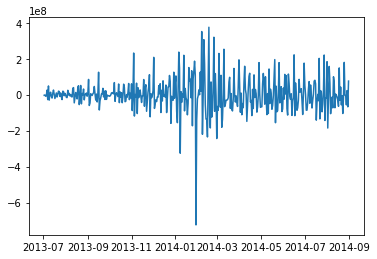

In [22]:
# 由于t值均小于不同程度拒绝原假设的统计值，同时p值也接近于0，一次差分平稳，可视化如下
plt.plot(diff1.total_purchase_amt)
plt.show()

In [54]:
from statsmodels.tsa.arima_model import ARIMA
from itertools import product

def arima(data, d=1):
    # 设置参数范围, d=1
    ps = range(0, 7)
    qs = range(0, 7)
    params = product(ps, qs)
    param_list = list(params)
    param_list
    
    # 寻找最优模型参数，即best_aic最小
    results = []
    best_aic = float("inf")
    for param in param_list:
        try:
            model = ARIMA(data,order=(param[0], d, param[1])).fit()
        except Exception as e:
#             print(e) # 参数错误或模型不收敛
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    return best_model

In [56]:
# typ='levels'即在原始数据上进行预测，相当于反差分
model_p1 = arima(purchase)
print('最优模型: ', model_p1.summary())
purchase_pred = model_p1.predict('2014-09-01', '2014-09-30', typ='levels')

最优模型:                                ARIMA Model Results                               
Dep. Variable:     D.total_purchase_amt   No. Observations:                  426
Model:                   ARIMA(5, 1, 6)   Log Likelihood               -8322.640
Method:                         css-mle   S.D. of innovations       73534516.246
Date:                  Fri, 04 Dec 2020   AIC                          16671.280
Time:                          20:35:40   BIC                          16723.987
Sample:                      07-02-2013   HQIC                         16692.100
                           - 08-31-2014                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       5.695e+05   5.94e+05      0.959      0.338   -5.94e+05    1.73e+06
ar.L1.D.total_purchase_amt     1.2166      0.101     12.094 

##### 对于赎回量redeem

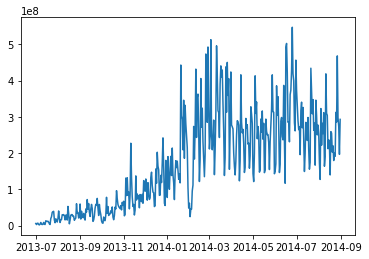

In [29]:
plt.plot(redeem.total_redeem_amt)
plt.show()

In [30]:
adf(redeem)

                                value
Test Statistic Value         -1.37241
p-value                      0.595428
Lags Used                          13
Number of Observations Used       413
Critical Value(1%)           -3.44628
Critical Value(5%)           -2.86856
Critical Value(10%)          -2.57051


In [33]:
# 由于t值均大于不同程度拒绝原假设的统计值
# 同时p值大于0.01，0.05，0.1，错误拒绝的并非小概率事件
# 故接受原假设，即原序列并非平稳，需进一步检验一次差分
diff1 = purchase.diff(1).dropna()
adf(diff1)

                                   value
Test Statistic Value             -7.9471
p-value                      3.19819e-12
Lags Used                             18
Number of Observations Used          407
Critical Value(1%)              -3.44652
Critical Value(5%)              -2.86867
Critical Value(10%)             -2.57057


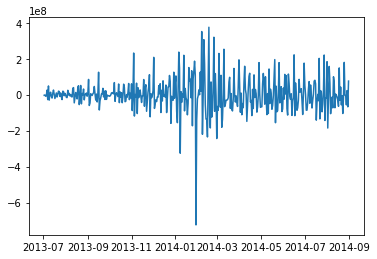

In [32]:
# 由于t值均小于不同程度拒绝原假设的统计值，同时p值也接近于0，一次差分平稳，可视化如下
plt.plot(diff1.total_purchase_amt)
plt.show()

In [55]:
# typ='levels'即在原始数据上进行预测，相当于反差分
model_r1 = arima(redeem)
print('最优模型: ', model_r1.summary())
redeem_pred = model_r1.predict('2014-09-01', '2014-09-30', typ='levels')

最优模型:                               ARIMA Model Results                              
Dep. Variable:     D.total_redeem_amt   No. Observations:                  426
Model:                 ARIMA(6, 1, 5)   Log Likelihood               -8232.400
Method:                       css-mle   S.D. of innovations       58242434.494
Date:                Fri, 04 Dec 2020   AIC                          16490.800
Time:                        20:34:57   BIC                          16543.507
Sample:                    07-02-2013   HQIC                         16511.620
                         - 08-31-2014                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     6.747e+05        nan        nan        nan         nan         nan
ar.L1.D.total_redeem_amt     1.0549        nan        nan        nan         nan  

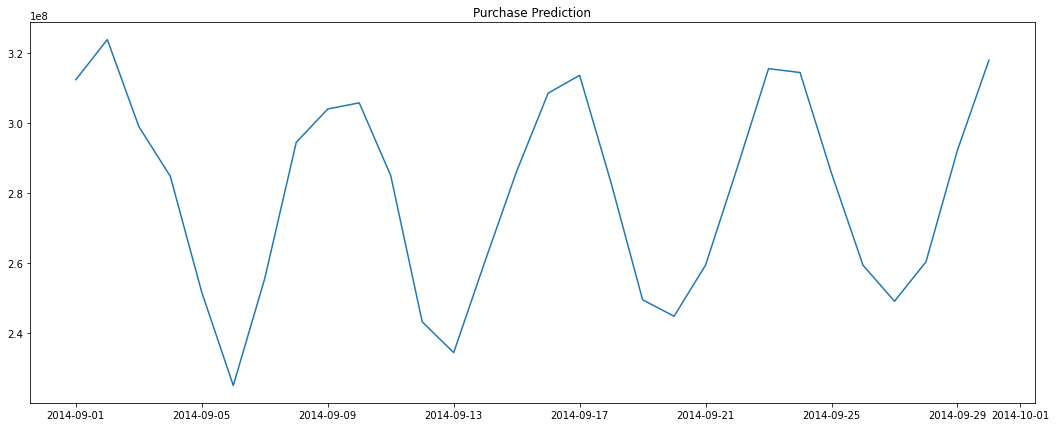

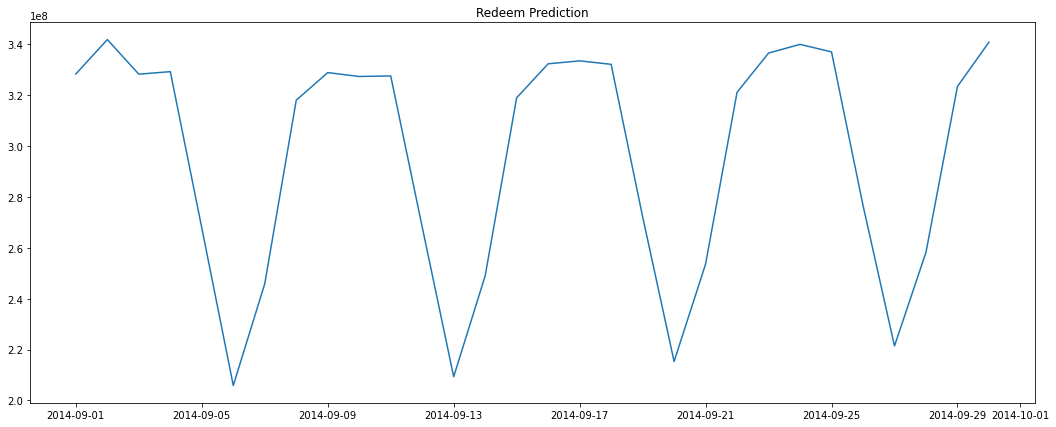

In [60]:
plt.figure(figsize=(18,7))
plt.plot(purchase_pred)
plt.title('Purchase Prediction')
plt.show()

plt.figure(figsize=(18,7))
plt.plot(redeem_pred)
plt.title('Redeem Prediction')
plt.show()

In [ ]:
# purchase_pred

In [66]:
# 合并结果
result = pd.DataFrame()
result['date'] = purchase_pred.index
result['total_purchase_amt'] = purchase_pred.values
result['total_redeem_amt'] = redeem_pred.values
result['date'] = result['date'].apply(lambda x: str(x).replace('-', '')[:8])
result

,date,total_purchase_amt,total_redeem_amt
0,20140901,3.123990e+08,3.282285e+08
1,20140902,3.238502e+08,3.417339e+08
2,20140903,2.990288e+08,3.281448e+08
3,20140904,2.848041e+08,3.291389e+08
4,20140905,2.516704e+08,2.677353e+08
5,20140906,2.250920e+08,2.058817e+08
6,20140907,2.556667e+08,2.458722e+08
7,20140908,2.945082e+08,3.179318e+08
8,20140909,3.040246e+08,3.287605e+08
9,20140910,3.057921e+08,3.272436e+08


In [67]:
result.to_csv('./arima.csv', header=None, index=False)
# finalScore:93.8533

#### 周期因子

##### 数据处理

In [321]:
# 给数据添加时间维度(年、月、周、日、星期几)
def add_timestamp(data):
    # 时间格式转换
    data['report_date'] = pd.to_datetime(data['report_date'], format='%Y%m%d')
    # 添加时间维度
#     data['year'] = data['report_date'].dt.year
#     data['month'] = data['report_date'].dt.month
    data['day'] = data['report_date'].dt.day
#     data['week'] = data['report_date'].dt.week
    data['weekday'] = data['report_date'].dt.weekday
    return data

In [322]:
# 0代表周一
data = add_timestamp(data)
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4,day,weekday
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN,5,1
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN,8,4
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN,11,0
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN,14,3
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN,17,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,0,0,0,61,NaN,NaN,NaN,NaN,25,0
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,0,0,0,60,0.0,0.0,0.0,12500.0,31,6
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,0,0,0,2297,NaN,NaN,NaN,NaN,24,3
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,31732,0,31732,2298,NaN,NaN,NaN,NaN,27,6


In [323]:
data['weekday'].value_counts()

6    410701
5    408824
4    407509
3    405907
2    404159
1    402536
0    400785
Name: weekday, dtype: int64

In [324]:
# 得到指定日期后的数据
def get_total_balance(data, begin):
    temp = data.copy()
    
    # 按照日期进行聚合（聚合后index为report_date
    temp = temp.groupby(['report_date'])['total_purchase_amt', 'total_redeem_amt'].sum()
    
    # reset_index
    temp.reset_index(inplace=True)
    temp = temp[temp['report_date']>=begin]
#     print(temp)
    return temp
    
# 得到2014-03-01后的数据
total_balance = get_total_balance(data, '2014-03-01')

In [325]:
# 生成测试数据
import numpy as np
def generate_future(data, start, end):
    total_balance = data.copy()
    temp = pd.DataFrame(pd.date_range(start,end))
    temp['total_purchase_amt'] = np.nan
    temp['total_redeem_amt'] = np.nan
    temp.rename(columns={0:'report_date'}, inplace=True)
    total_balance = pd.concat([total_balance,temp])
    return total_balance

total_balance = generate_future(total_balance, '2014-09-01', '2014-09-30')
total_balance = add_timestamp(total_balance)
total_balance

,report_date,total_purchase_amt,total_redeem_amt,day,weekday
243,2014-03-01,362865580.0,211279011.0,1,5
244,2014-03-02,276202230.0,246199417.0,2,6
245,2014-03-03,505305862.0,513017360.0,3,0
246,2014-03-04,524146340.0,250562978.0,4,1
247,2014-03-05,454295491.0,209072753.0,5,2
...,...,...,...,...,...
25,2014-09-26,NaN,NaN,26,4
26,2014-09-27,NaN,NaN,27,5
27,2014-09-28,NaN,NaN,28,6
28,2014-09-29,NaN,NaN,29,0


In [326]:
future_balance = pd.DataFrame(pd.date_range('2014-09-01', '2014-09-30'))
future_balance.rename(columns={0:'report_date'}, inplace=True)
future_balance = add_timestamp(future_balance)

In [327]:
# 存储备份
temp = total_balance.copy()

In [328]:
total_balance = temp.copy()

##### 计算weekday权重

In [329]:
weekday_weight = total_balance[['weekday', 'total_purchase_amt', 'total_redeem_amt']].groupby(['weekday'], as_index=False).mean()
weekday_weight.rename(columns={'total_purchase_amt': 'purchase_weekday', 'total_redeem_amt':'redeem_weekday'}, inplace=True)
weekday_weight

,weekday,purchase_weekday,redeem_weekday
0,0,3.273693e+08,3.456808e+08
1,1,3.340518e+08,3.221266e+08
2,2,3.213877e+08,3.181960e+08
3,3,3.146910e+08,2.821480e+08
4,4,2.492893e+08,2.680463e+08
5,5,1.958666e+08,1.840544e+08
6,6,1.966477e+08,2.093138e+08


In [330]:
weekday_weight['purchase_weekday'] /= np.mean(total_balance['total_purchase_amt'])
weekday_weight['redeem_weekday'] /= np.mean(total_balance['total_redeem_amt'])
weekday_weight

,weekday,purchase_weekday,redeem_weekday
0,0,1.185411,1.257964
1,1,1.209608,1.172248
2,2,1.163752,1.157944
3,3,1.139503,1.026762
4,4,0.902682,0.975445
5,5,0.709237,0.669791
6,6,0.712065,0.761712


In [331]:
total_balance = pd.merge(total_balance, weekday_weight, on='weekday', how='left')
future_balance = pd.merge(future_balance, weekday_weight, on='weekday', how='left')

##### 统计周一到周日在1-31号出现的频次  
（1号有几个周一，几个周二...）

In [332]:
total_balance[['report_date', 'weekday', 'day']].groupby(['day', 'weekday']).count()

report_date
day weekday             
1   0                  1
    1                  2
    3                  1
    4                  1
    5                  1
...                  ...
30  6                  1
31  0                  1
    3                  1
    5                  1
    6                  1

[184 rows x 1 columns]

In [333]:
total_balance[['report_date', 'day']].groupby(['day'], as_index=False).count()

,day,report_date
0,1,7
1,2,7
2,3,7
3,4,7
4,5,7
5,6,7
6,7,7
7,8,7
8,9,7
9,10,7


In [334]:
weekday_count = total_balance[['report_date', 'weekday', 'day']].groupby(['day', 'weekday'], as_index=False).count()
weekday_count.rename(columns={'report_date': 'count'}, inplace=True)
day_count = total_balance[['report_date', 'day']].groupby(['day'], as_index=False).count()
day_count.rename(columns={'report_date': 'day_count'}, inplace=True)
weekday_count = pd.merge(weekday_count, weekday_weight, on='weekday', how='left')
weekday_count = pd.merge(weekday_count, day_count, on='day', how='left')
weekday_count

,day,weekday,count,purchase_weekday,redeem_weekday,day_count
0,1,0,1,1.185411,1.257964,7
1,1,1,2,1.209608,1.172248,7
2,1,3,1,1.139503,1.026762,7
3,1,4,1,0.902682,0.975445,7
4,1,5,1,0.709237,0.669791,7
...,...,...,...,...,...,...
179,30,6,1,0.712065,0.761712,7
180,31,0,1,1.185411,1.257964,4
181,31,3,1,1.139503,1.026762,4
182,31,5,1,0.709237,0.669791,4


##### 周期因子加权得到日期因子

In [335]:
weekday_count['purchase_day'] = weekday_count['purchase_weekday'] * weekday_count['count']/weekday_count['day_count']
weekday_count['redeem_day'] = weekday_count['redeem_weekday'] * weekday_count['count']/weekday_count['day_count']

In [336]:
weekday_count

,day,weekday,count,purchase_weekday,redeem_weekday,day_count,purchase_day,redeem_day
0,1,0,1,1.185411,1.257964,7,0.169344,0.179709
1,1,1,2,1.209608,1.172248,7,0.345602,0.334928
2,1,3,1,1.139503,1.026762,7,0.162786,0.146680
3,1,4,1,0.902682,0.975445,7,0.128955,0.139349
4,1,5,1,0.709237,0.669791,7,0.101320,0.095684
...,...,...,...,...,...,...,...,...
179,30,6,1,0.712065,0.761712,7,0.101724,0.108816
180,31,0,1,1.185411,1.257964,4,0.296353,0.314491
181,31,3,1,1.139503,1.026762,4,0.284876,0.256691
182,31,5,1,0.709237,0.669791,4,0.177309,0.167448


In [337]:
day_weight = weekday_count[['day', 'purchase_day', 'redeem_day']].groupby('day', as_index=False).sum()
day_weight

,day,purchase_day,redeem_day
0,1,1.009731,1.005167
1,2,1.006644,1.021864
2,3,1.037011,1.010455
3,4,1.030815,1.046789
4,5,1.002776,0.989992
5,6,0.935559,0.932230
6,7,0.999723,1.015369
7,8,1.009731,1.005167
8,9,1.006644,1.021864
9,10,1.037011,1.010455


##### 计算base
按照日期计算均值/日期因子（排除周期因子的影响）

In [338]:
day_mean = total_balance[['day', 'total_purchase_amt', 'total_redeem_amt']].groupby('day', as_index=False).mean()
day_base = pd.merge(day_mean, day_weight, on='day', how='left')
day_base['total_purchase_amt'] /= day_base['purchase_day']
day_base['total_redeem_amt'] /= day_base['purchase_day']
day_base.drop(['purchase_day', 'redeem_day'], axis=1, inplace=True)
day_base

,day,total_purchase_amt,total_redeem_amt
0,1,3.222038e+08,2.325052e+08
1,2,2.464879e+08,2.171646e+08
2,3,2.887923e+08,2.862310e+08
3,4,3.065345e+08,2.838141e+08
4,5,3.277176e+08,2.545419e+08
5,6,3.204986e+08,2.630468e+08
6,7,2.837511e+08,2.375496e+08
7,8,2.890537e+08,2.451401e+08
8,9,2.837750e+08,2.424164e+08
9,10,3.323346e+08,2.501278e+08


##### 进行预测

In [339]:
pred = pd.merge(future_balance, day_base, on='day', how='left')
pred['total_purchase_amt'] *= pred['purchase_weekday']
pred['total_redeem_amt'] *= pred['redeem_weekday']
result = pred[['report_date', 'total_purchase_amt', 'total_redeem_amt']]
result

,report_date,total_purchase_amt,total_redeem_amt
0,2014-09-01,3.819439e+08,2.924831e+08
1,2014-09-02,2.981538e+08,2.545707e+08
2,2014-09-03,3.360825e+08,3.314395e+08
3,2014-09-04,3.492969e+08,2.914096e+08
4,2014-09-05,2.958247e+08,2.482916e+08
5,2014-09-06,2.273095e+08,1.761863e+08
6,2014-09-07,2.020493e+08,1.809443e+08
7,2014-09-08,3.426474e+08,3.083774e+08
8,2014-09-09,3.432566e+08,2.841721e+08
9,2014-09-10,3.867549e+08,2.896341e+08


In [340]:
result['report_date'] = result['report_date'].apply(lambda x: str(x).replace('-', '')[:8])
result.to_csv('./weekday_feature.csv', header=None, index=False)
# finalScore:130.7797